In [1]:
import numpy as np
import copy
import numpy.ma as ma
import csv
import nimfa  # non-negative matrix factorization

#functions
def save_approx(name_of_the_list, approx, i):
    if i == 1 or i == 2 or i == 3 or i==4:  # save approx for rank 1, rank 2 and rank 3
        name_of_the_list.append(approx)
        
import sys
sys.path.append("..")
import utils as ut
import distance_correlation as dc
import STMF as stmf  # sparse tropical matrix factorization

/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/cbcl_images.py:98: UserWarning: PIL must be installed to run CBCL images example.
  warn("PIL must be installed to run CBCL images example.")
/home/amra/miniconda3/envs/NMF_vs_TMF/lib/python3.6/site-packages/nimfa/examples/orl_images.py:110: UserWarning: PIL must be installed to run ORL images example.
  warn("PIL must be installed to run ORL images example.")


In [2]:
m = 200  # number of rows, 200
n = 100  # number of columns, 100
rank = 3  # rank
missing_value = 0  # 99 is better than 0, because 0 can be the real value in data; 0 because of nmf!
A = ma.masked_array(np.random.rand(m, rank), mask=np.zeros((m, rank)))  # uniform distribution over [0, 1)
B = ma.masked_array(np.random.rand(n, rank), mask=np.zeros((n, rank)))
temp = 5  # 21, until rank 4
repeat = 10  # 10
max_iter = 500
sparsity = 0.2  # 20%
init = 'nndsvd'  # random, random_c, random_vcol, nndsvd
init_tmf = 'random_vcol'

X_maxplus_orig = ut.max_plus(A, B.T)
ut.check_zeros(X_maxplus_orig)
# polo clustering
X_maxplus_orig, row_perm, col_perm = ut.polo_clustering(X_maxplus_orig) # [0] returns matrix, [1] and [2] returns permutations
X_maxplus = copy.deepcopy(X_maxplus_orig)

X_maxplus = ut.create_matrix_with_missing_values(X_maxplus, sparsity, missing_value)  # create matrix with missing values
X_missing_values = copy.deepcopy(X_maxplus)
X_maxplus = ma.masked_equal(X_maxplus, missing_value)  # create masked array
#X_maxplus /= X_maxplus.sum()

In [3]:
print(np.max(X_maxplus_orig))

1.9972402452508446


In [4]:
# PMF
print("PMF")
errors_pmf, corr_pmf, rmse_pmf = np.array([]), np.array([]), np.array([])
approx_pmf = []
U_pmf, V_pmf = 0, 0
for i in range(1, temp):
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    model = nimfa.Pmf(X_maxplus, rank=i, max_iter=max_iter, seed=init)
    #start_time_pmf = time.time()
    pmf = model()
    #t_pmf = round(time.time() - start_time_pmf, 3)
    approx = np.dot(pmf.basis(), pmf.coef(idx=None))
    if i == 4:  # rank 3, all approximations of rank 3 are the same since nndsvd is non-randomized
        U_pmf = pmf.basis()
        V_pmf = pmf.coef(idx=None)
    error_iter = np.append(error_iter, ut.rmse(X_maxplus_orig, X_missing_values, approx, missing_value))
    correlation, a, b = dc.dcor(X_maxplus_orig, approx)
    if i==4:
        print("rank " + str(i) + ": " + str(correlation))
    corr_iter = np.append(corr_iter, correlation)
    correlations.append(correlation)
    approximations.append(approx)
    rmse_iter = np.append(rmse_iter, ut.rmse_approx(X_maxplus_orig, X_missing_values, approx, missing_value))
    save_approx(approx_pmf, approximations[np.argmax(correlations)], i)
    errors_pmf, corr_pmf, rmse_pmf = np.append(errors_pmf, error_iter), np.append(corr_pmf, corr_iter), np.append(rmse_pmf, rmse_iter)

PMF
rank 4: 0.8695920533679254


In [5]:
# NMF
errors_nmf_maxplus, corr_nmf_maxplus, rmse_nmf = np.array([]), np.array([]), np.array([])
approx_nmf_maxplus = []
U_nmf, V_nmf = 0, 0
for i in range(1, temp):
    #print("rank " + str(i))
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = nimfa.Nmf(X_maxplus, rank=i, max_iter=max_iter, seed=init)
        nmf = model()
        approx = np.dot(nmf.basis(), nmf.coef(idx=None))
        if i == 4:  # rank 3, all approximations of rank 3 are the same since nndsvd is non-randomized
            U_nmf = nmf.basis()
            V_nmf = nmf.coef(idx=None) 
        error_iter = np.append(error_iter, ut.rmse(X_maxplus_orig, X_missing_values, approx, missing_value))
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(X_maxplus_orig, X_missing_values, approx, missing_value))
        correlation, a, b = dc.dcor(X_maxplus_orig, approx)
        corr_iter = np.append(corr_iter, correlation)
        correlations.append(correlation)
        approximations.append(approx)
    save_approx(approx_nmf_maxplus, approximations[np.argmax(correlations)], i)
    errors_nmf_maxplus, corr_nmf_maxplus, rmse_nmf = np.append(errors_nmf_maxplus, error_iter), np.append(corr_nmf_maxplus, corr_iter), np.append(rmse_nmf, rmse_iter)

# STMF
errors_trop_maxplus, corr_trop_maxplus, rmse_trop = np.array([]), np.array([]), np.array([])
approx_trop_maxplus = []
factor_U, factor_V = [], []
U_stmf, V_stmf = 0, 0
for i in range(1, temp):
    #print("rank " + str(i))
    error_iter, corr_iter, rmse_iter = np.array([]), np.array([]), np.array([])
    correlations, approximations = [], []
    for j in range(0, repeat):
        model = stmf.STMF(rank=i, criterion='iterations', max_iter=max_iter, initialization=init_tmf)
        model.fit(X_maxplus)
        if i == 4:
            factor_U.append(model.U)
            factor_V.append(model.V)
        approx = model.predict_all()
        error_iter = np.append(error_iter, ut.rmse(X_maxplus_orig, X_missing_values, approx, missing_value))
        rmse_iter = np.append(rmse_iter, ut.rmse_approx(X_maxplus_orig, X_missing_values, approx, missing_value))
        correlation, a, b = dc.dcor(X_maxplus_orig, approx)
        corr_iter = np.append(corr_iter, correlation)
        correlations.append(correlation)
        approximations.append(approx)
    save_approx(approx_trop_maxplus, approximations[np.argmax(correlations)], i)
    if i == 4:
        U_stmf, V_stmf = factor_U[np.argmax(correlations)], factor_V[np.argmax(correlations)]
    errors_trop_maxplus, corr_trop_maxplus, rmse_trop =  np.append(errors_trop_maxplus, error_iter), np.append(corr_trop_maxplus, corr_iter), np.append(rmse_trop, rmse_iter)

### VISUALIZATIONS

Approximation matrices

In [6]:
approx_nmf = approx_nmf_maxplus[3]
approx_pmf_x = approx_pmf[3]
approx_stmf = approx_trop_maxplus[3]

In [7]:
diff_nmf = np.subtract(approx_nmf, X_maxplus)
diff_pmf = np.subtract(approx_pmf_x, X_maxplus)
diff_stmf = np.subtract(approx_stmf, X_maxplus)
### min and max
min_nmf, min_pmf, min_stmf = np.min(diff_nmf), np.min(diff_pmf), np.min(diff_stmf)
max_nmf, max_pmf, max_stmf = np.max(diff_nmf), np.max(diff_pmf), np.max(diff_stmf)
### final min and max
final_min, final_max = min([min_nmf, min_pmf, min_stmf]), max([max_nmf, max_pmf, max_stmf])

In [8]:
limit = max(abs(final_min), abs(final_max))
final_min = -limit
final_max = limit

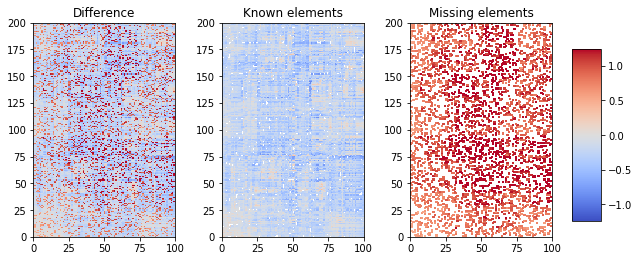

In [9]:
ut.plot_diff(X_maxplus, approx_nmf, final_min, final_max, "results/rank_4/diff_random_missing_nmf.png")

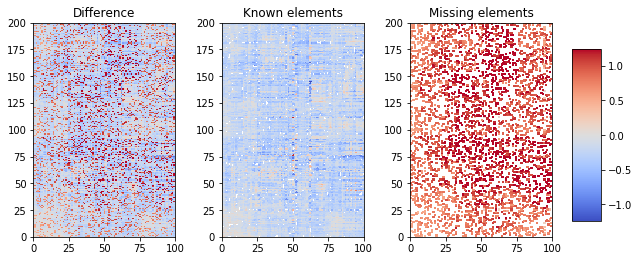

In [10]:
ut.plot_diff(X_maxplus, approx_pmf_x, final_min, final_max, "results/rank_4/diff_random_missing_pmf.png")

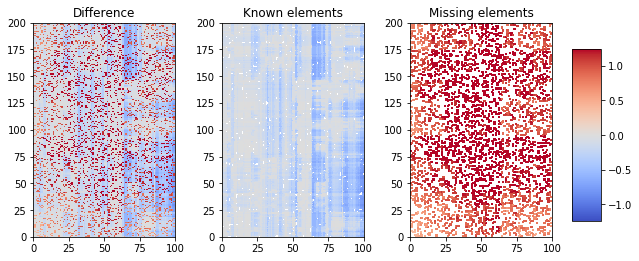

In [11]:
ut.plot_diff(X_maxplus, approx_stmf, final_min, final_max, "results/rank_4/diff_random_missing_stmf.png")

In [12]:
diff_nmf = np.absolute(np.subtract(approx_nmf, X_maxplus))
diff_pmf = np.absolute(np.subtract(approx_pmf_x, X_maxplus))
diff_stmf = np.absolute(np.subtract(approx_stmf, X_maxplus))
### min and max
min_nmf, min_pmf, min_stmf = np.min(diff_nmf), np.min(diff_pmf), np.min(diff_stmf)
max_nmf, max_pmf, max_stmf = np.max(diff_nmf), np.max(diff_pmf), np.max(diff_stmf)
### final min and max
final_min, final_max = min([min_nmf, min_pmf, min_stmf]), max([max_nmf, max_pmf, max_stmf])

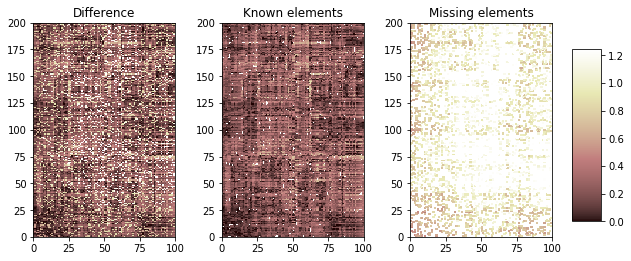

In [13]:
ut.plot_diff_abs(X_maxplus, approx_nmf, final_min, final_max, "results/rank_4/diff_random_missing_nmf_abs.png")

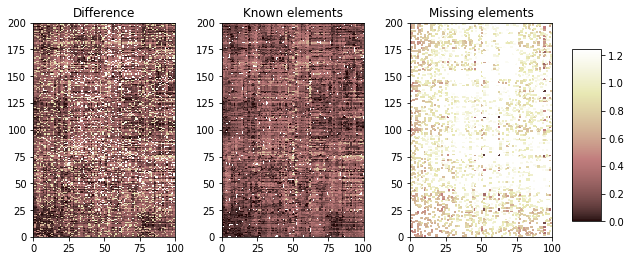

In [14]:
ut.plot_diff_abs(X_maxplus, approx_pmf_x, final_min, final_max, "results/rank_4/diff_random_missing_pmf_abs.png")

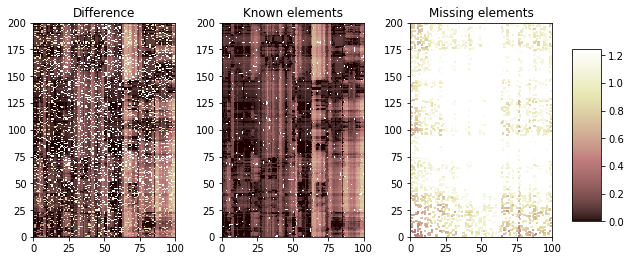

In [15]:
ut.plot_diff_abs(X_maxplus, approx_stmf, final_min, final_max, "results/rank_4/diff_random_missing_stmf_abs.png")

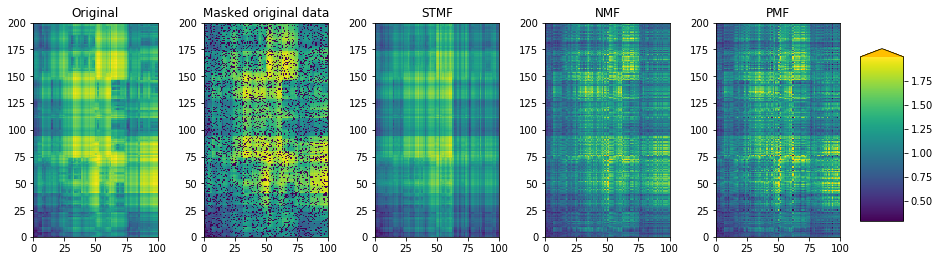

In [16]:
ut.plot_synth_three_methods_origmax(X_maxplus_orig, X_maxplus, approx_stmf, approx_nmf, approx_pmf_x, "", "results/rank_4/synth_three_methods.png")

## Mean values

In [17]:
print("Original:")
np.mean(X_maxplus_orig)

Original:


1.3360364241843063

In [18]:
print("NMF:")
np.mean(approx_nmf)

NMF:


1.0931587222854413

In [19]:
print("PMF:")
np.mean(approx_pmf_x)

PMF:


1.0928046857545541

In [20]:
print("STMF:")
np.mean(approx_stmf)

STMF:


1.1632239917256229